# Full pipeline for node embeddings

This code represents a full pipeline for **node embeddings**.
We will go through the following 3 steps.

 1. To start, we will load a classic graph.

 2. transform the graph structure into a PyTorch tensor, so that we can perform machine learning over the graph.

 3. Finish thelearning algorithm on graphs: a node embedding model. 

# 1. Graph Basics
Load a classic graph, the Karate Club Network

In [27]:
import networkx as nx

In [28]:
G = nx.karate_club_graph()
G.is_directed()
club_labels = nx.get_node_attributes(G,'club')
# Show some labels
print({key:club_labels[key] for key in range(1,16)})


{1: 'Mr. Hi', 2: 'Mr. Hi', 3: 'Mr. Hi', 4: 'Mr. Hi', 5: 'Mr. Hi', 6: 'Mr. Hi', 7: 'Mr. Hi', 8: 'Mr. Hi', 9: 'Officer', 10: 'Mr. Hi', 11: 'Mr. Hi', 12: 'Mr. Hi', 13: 'Mr. Hi', 14: 'Officer', 15: 'Officer'}


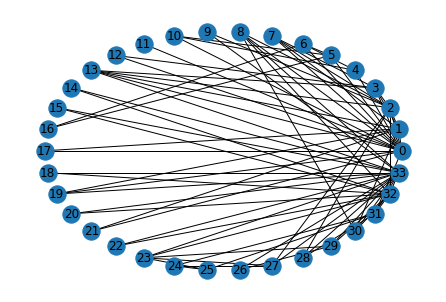

In [29]:
# Use a ciruclar layout to visualize the graph
circ_pos = nx.circular_layout(G) 
nx.draw(G,circ_pos,with_labels = True)

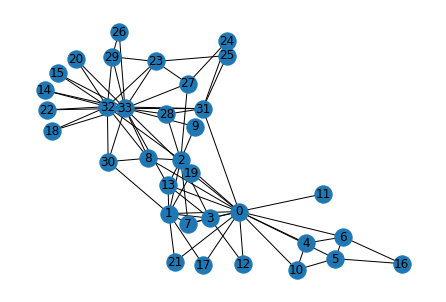

In [30]:
# Visualize the graph
nx.draw(G, with_labels = True)

## Edge density of the karate club network

In [31]:
density = nx.density(G)

print('The edge density is {} '.format(density))

The edge density is 0.13903743315508021 


## Average degree of the karate club network

In [32]:
def average_degree(num_edges, num_nodes):
    avg_degree = round((2*num_edges) / num_nodes)
    return avg_degree

num_edges = G.number_of_edges()
num_nodes = G.number_of_nodes()
avg_degree = average_degree(num_edges, num_nodes)
print("Average degree of karate club network is {}".format(avg_degree))

Average degree of karate club network is 5


Text(0.5, 1.0, 'Karate Club: Node Degree')

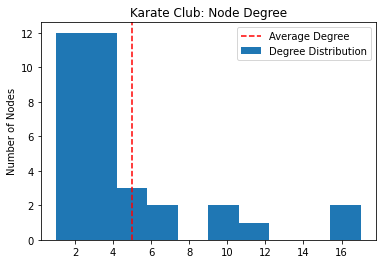

In [33]:
import matplotlib.pyplot as plt

# Get list of the Graph nodes degree
degree = G.degree()
degree_list = []
for (n,d) in degree:
    degree_list.append(d)

# Plot the degree distribution and compare to average degree
plt.hist(degree_list,label='Degree Distribution')
plt.axvline(avg_degree,color='r',linestyle='dashed',label='Average Degree')
plt.legend()
plt.ylabel('Number of Nodes')
plt.title('Karate Club: Node Degree')

## Average clustering coefficient of the karate club network

In [34]:
from networkx.algorithms.approximation.clustering_coefficient import average_clustering

def average_clustering_coefficient(G):
    avg_cluster_coef = 0
    # Get average clustering coefficient
    avg_cluster_coef = round(average_clustering(G),2)
    return avg_cluster_coef

avg_cluster_coef = average_clustering_coefficient(G)
print("Average clustering coefficient of karate club network is {}".format(avg_cluster_coef))

Average clustering coefficient of karate club network is 0.59


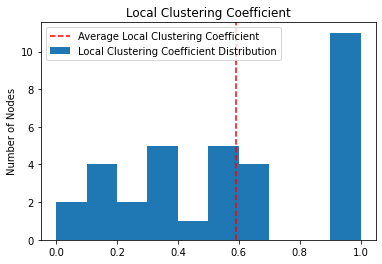

In [35]:
# Get local clustering coefficient
loc_cluster_coef = nx.algorithms.cluster.clustering(G)

# Plot the local clustering coefficient distribution and compare to average clustering coefficient
plt.hist(loc_cluster_coef.values(),label='Local Clustering Coefficient Distribution')
plt.axvline(avg_cluster_coef,color='r',linestyle='dashed',label='Average Local Clustering Coefficient')
plt.legend()
plt.ylabel('Number of Nodes')
plt.title('Local Clustering Coefficient')
plt.show()

## PageRank value for node 0 after one PageRank iteration

Implementing the PageRank equation: $r_j = \sum_{i \rightarrow j} \beta \frac{r_i}{d_i} + (1 - \beta) \frac{1}{N}$

In [36]:
def one_iter_pagerank(G, beta, r0, node_id):
  r1 = 0
  in_nodes_d = {}
  # Get edges adjacent to all neighbors of  node node_id
  for n in list(G.neighbors(node_id)): # For all neighbors of node node_id
    count = 0    
    # Get edges adjacent to n
    in_nodes_d[n] = G.degree(n) 
  # PageRank equation
  for k, v in in_nodes_d.items():
    r1 += beta * float(r0)/v
  
  r1 += (1 - beta) / G.number_of_nodes()
  return r1

beta = 0.8
r0 = 1 / G.number_of_nodes()
node = 0
r1 = one_iter_pagerank(G, beta, r0, node)
print("The PageRank value for node 0 after one iteration is {}".format(r1))

The PageRank value for node 0 after one iteration is 0.12810457516339868


## Closeness centrality for the karate club network node 5


In [37]:
from networkx.algorithms import centrality

def closeness_centrality(G, node=5):
  closeness = 0
  closeness = centrality.closeness_centrality(G, node)
  return closeness

node = 5
closeness = closeness_centrality(G,node)
print("The node 5 has closeness centrality {}".format(closeness))

The node 5 has closeness centrality 0.38372093023255816


# 2. Graph to Tensor
Transform the graph $G$ into a PyTorch tensor, so that we can perform machine learning over the graph.

## Setup
Check if PyTorch is properly installed

In [38]:
import torch
print(torch.__version__)

1.11.0


## PyTorch tensor basics

We can generate PyTorch tensor with all zeros, ones or random values.

In [39]:
# Generate 3 x 4 tensor with all ones
ones = torch.ones(3, 4)
print(ones)

# Generate 3 x 4 tensor with all zeros
zeros = torch.zeros(3, 4)
print(zeros)

# Generate 3 x 4 tensor with random values on the interval [0, 1]
random_tensor = torch.rand(3, 4)
print(random_tensor)

# Get the shape of the tensor
print(ones.shape)

tensor([[1., 1., 1., 1.],
        [1., 1., 1., 1.],
        [1., 1., 1., 1.]])
tensor([[0., 0., 0., 0.],
        [0., 0., 0., 0.],
        [0., 0., 0., 0.]])
tensor([[0.2114, 0.7335, 0.1433, 0.9647],
        [0.2933, 0.7951, 0.5170, 0.2801],
        [0.8339, 0.1185, 0.2355, 0.5599]])
torch.Size([3, 4])


PyTorch tensor contains elements for a single data type, the `dtype`.

In [40]:
# Create a 3 x 4 tensor with all 32-bit floating point zeros
zeros = torch.zeros(3, 4, dtype=torch.float32)
print(zeros.dtype)

# Change the tensor dtype to 64-bit integer
zeros = zeros.type(torch.long)
print(zeros.dtype)

torch.float32
torch.int64


## Get the edge list of the karate club network and transform it into `torch.LongTensor`

In [41]:
def graph_to_edge_list(G):
    edge_list = []
    edge_list = list(G.edges())
    return edge_list

def edge_list_to_tensor(edge_list):

    edge_index = torch.tensor([])
    edge_index = torch.tensor(edge_list, dtype = torch.long).permute((1,0))

    return edge_index

pos_edge_list = graph_to_edge_list(G)
pos_edge_index = edge_list_to_tensor(pos_edge_list)
print("The pos_edge_index tensor has shape {}".format(pos_edge_index.shape))
print("The pos_edge_index tensor has sum value {}".format(torch.sum(pos_edge_index)))

The pos_edge_index tensor has shape torch.Size([2, 78])
The pos_edge_index tensor has sum value 2535


## Which edges (edge_1 to edge_5) can be potential negative edges in the karate club network

In [42]:
import random

def sample_negative_edges(G, num_neg_samples):
    
    neg_edge_list = []

    pos_set = set(G.edges())
    visited_set = set()

    for n_i in G.nodes():
        for n_j in G.nodes():
            if n_i == n_j or (n_i,n_j) in pos_set or (n_j,n_i) in pos_set or (n_i,n_j) in visited_set or (n_j, n_i) is visited_set:
                continue
            neg_edge_list.append((n_i,n_j))
            visited_set.add((n_i,n_j))
            visited_set.add((n_j,n_i))
            if len(neg_edge_list) == num_neg_samples:
                break

    return neg_edge_list

# Sample 78 negative edges
neg_edge_list = sample_negative_edges(G, len(pos_edge_list))

# Transform the negative edge list to tensor
neg_edge_index = edge_list_to_tensor(neg_edge_list)
print("The neg_edge_index tensor has shape {}".format(neg_edge_index.shape))

# Which of following edges can be negative ones?
edge_1 = (7, 1)
edge_2 = (1, 33)
edge_3 = (33, 22)
edge_4 = (0, 4)
edge_5 = (4, 2)

############# Your code here ############
## Note:
## 1: For each of the 5 edges, print whether it can be negative edge

#########################################

The neg_edge_index tensor has shape torch.Size([2, 483])


# 3 Node Emebedding Learning

Finally, we will finish the first learning algorithm on graphs: a node embedding model.


## Setup

In [43]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

To write your own node embedding learning methods, use the [`nn.Embedding`](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html) module in PyTorch. 

In [44]:
# Initialize an embedding layer
# Suppose we want to have embedding for 4 items (e.g., nodes)
# Each item is represented with 8 dimensional vector

emb_sample = nn.Embedding(num_embeddings=4, embedding_dim=8)
print('Sample embedding layer: {}'.format(emb_sample))

Sample embedding layer: Embedding(4, 8)


Select items from the embedding matrix, by using Tensor indices

In [45]:
# Select an embedding in emb_sample
id = torch.LongTensor([1])
print(emb_sample(id))

# Select multiple embeddings
ids = torch.LongTensor([1, 3])
print(emb_sample(ids))

# Get the shape of the embedding weight matrix
shape = emb_sample.weight.data.shape
print(shape)

# Overwrite the weight to tensor with all ones
emb_sample.weight.data = torch.ones(shape)

# Let's check if the emb is indeed initilized
ids = torch.LongTensor([0, 3])
print(emb_sample(ids))

tensor([[-1.7716, -0.0209,  0.5846,  0.6159, -0.4999,  0.0399, -0.7815,  0.3195]],
       grad_fn=<EmbeddingBackward0>)
tensor([[-1.7716, -0.0209,  0.5846,  0.6159, -0.4999,  0.0399, -0.7815,  0.3195],
        [-0.3314, -0.3489,  0.7679, -0.3329, -0.9173,  0.8372,  1.4950, -0.8303]],
       grad_fn=<EmbeddingBackward0>)
torch.Size([4, 8])
tensor([[1., 1., 1., 1., 1., 1., 1., 1.],
        [1., 1., 1., 1., 1., 1., 1., 1.]], grad_fn=<EmbeddingBackward0>)


Create node embedding matrix for the graph we have!
-  **16 dimensional** vector for each node in the karate club network.
- Iinitalize the matrix under **uniform distribution**, in  $[0, 1]$. 

In [46]:
torch.manual_seed(1)

def create_node_emb(num_node=34, embedding_dim=16):
    emb = None
    emb = torch.nn.Embedding(num_embeddings = num_node, embedding_dim = embedding_dim)
    return emb

emb = create_node_emb()
print(emb.weight.data.shape)
ids = torch.LongTensor([0, 3])

# Print the embedding layer
print("Embedding: {}".format(emb))

# Get the embeddings for node 0 and 3
print(emb(ids))

torch.Size([34, 16])
Embedding: Embedding(34, 16)
tensor([[-1.5256, -0.7502, -0.6540, -1.6095, -0.1002, -0.6092, -0.9798, -1.6091,
         -0.7121,  0.3037, -0.7773, -0.2515, -0.2223,  1.6871,  0.2284,  0.4676],
        [-0.9274,  0.5451,  0.0663, -0.4370,  0.7626,  0.4415,  1.1651,  2.0154,
          0.1374,  0.9386, -0.1860, -0.6446,  1.5392, -0.8696, -3.3312, -0.7479]],
       grad_fn=<EmbeddingBackward0>)


## Visualize the initial node embeddings
Visualize embedding matrix in a 2D space.


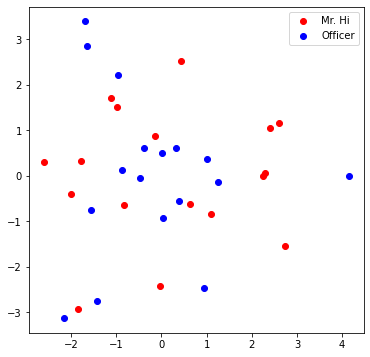

In [47]:
def visualize_emb(emb):
  X = emb.weight.data.numpy()
  pca = PCA(n_components=2)
  components = pca.fit_transform(X)
  plt.figure(figsize=(6, 6))
  club1_x = []
  club1_y = []
  club2_x = []
  club2_y = []
  for node in G.nodes(data=True):
    if node[1]['club'] == 'Mr. Hi':
      club1_x.append(components[node[0]][0])
      club1_y.append(components[node[0]][1])
    else:
      club2_x.append(components[node[0]][0])
      club2_y.append(components[node[0]][1])
  plt.scatter(club1_x, club1_y, color="red", label="Mr. Hi")
  plt.scatter(club2_x, club2_y, color="blue", label="Officer")
  plt.legend()
  plt.show()

# Visualize the initial random embeddding
visualize_emb(emb)

## Question 7: Training the embedding

C:\Users\Dell\condaa\anaconda3\lib\site-packages\torch\autograd\__init__.py:173: UserWarning: CUDA initialization: CUDA driver initialization failed, you might not have a CUDA gpu. (Triggered internally at  C:\cb\pytorch_1000000000000\work\c10\cuda\CUDAFunctions.cpp:112.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


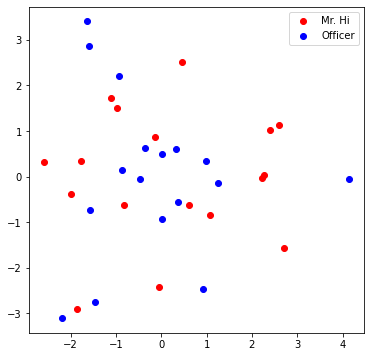

loss: 1.8108690977096558, accuracy: 0.5223
loss: 1.7991622686386108, accuracy: 0.5223
loss: 1.7779197692871094, accuracy: 0.5241
loss: 1.748146891593933, accuracy: 0.5241
loss: 1.71103036403656, accuracy: 0.5294
loss: 1.6687390804290771, accuracy: 0.533
loss: 1.6222254037857056, accuracy: 0.5365
loss: 1.572980284690857, accuracy: 0.5383
loss: 1.521982192993164, accuracy: 0.5455
loss: 1.4703664779663086, accuracy: 0.5419
loss: 1.418881893157959, accuracy: 0.5508
loss: 1.3682787418365479, accuracy: 0.5544
loss: 1.3190616369247437, accuracy: 0.5597
loss: 1.2716554403305054, accuracy: 0.5597
loss: 1.2263492345809937, accuracy: 0.5615
loss: 1.183327078819275, accuracy: 0.5704
loss: 1.1427043676376343, accuracy: 0.574
loss: 1.104521632194519, accuracy: 0.5722
loss: 1.068756103515625, accuracy: 0.5704
loss: 1.0353538990020752, accuracy: 0.574
loss: 1.0042225122451782, accuracy: 0.574
loss: 0.9752475619316101, accuracy: 0.5775
loss: 0.9482999444007874, accuracy: 0.5847
loss: 0.9232414960861206

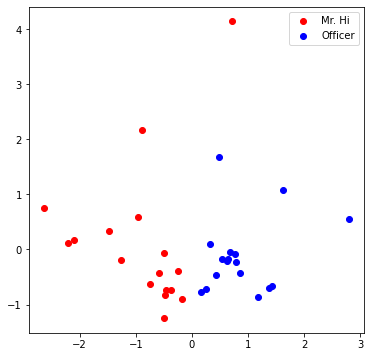

loss: 0.46622851490974426, accuracy: 0.7772
loss: 0.4648481011390686, accuracy: 0.7807
loss: 0.463489294052124, accuracy: 0.779
loss: 0.4621514081954956, accuracy: 0.779
loss: 0.46083369851112366, accuracy: 0.779
loss: 0.4595353901386261, accuracy: 0.779
loss: 0.4582558572292328, accuracy: 0.779
loss: 0.4569944739341736, accuracy: 0.779
loss: 0.45575055480003357, accuracy: 0.7825
loss: 0.4545235335826874, accuracy: 0.7825
loss: 0.4533129036426544, accuracy: 0.7843
loss: 0.4521179795265198, accuracy: 0.7843
loss: 0.45093834400177, accuracy: 0.7879
loss: 0.4497734606266022, accuracy: 0.7879
loss: 0.44862285256385803, accuracy: 0.7897
loss: 0.4474860429763794, accuracy: 0.7897
loss: 0.44636255502700806, accuracy: 0.7879
loss: 0.44525203108787537, accuracy: 0.7897
loss: 0.44415396451950073, accuracy: 0.7932
loss: 0.4430680274963379, accuracy: 0.795
loss: 0.441993772983551, accuracy: 0.795
loss: 0.44093090295791626, accuracy: 0.7968
loss: 0.4398789703845978, accuracy: 0.7986
loss: 0.4388376

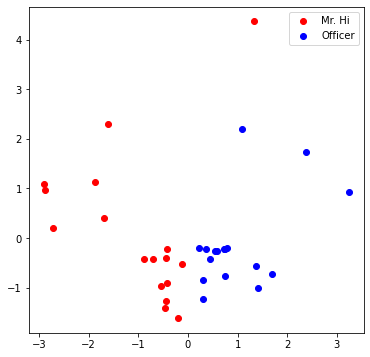

loss: 0.37542709708213806, accuracy: 0.861
loss: 0.374722957611084, accuracy: 0.861
loss: 0.3740207850933075, accuracy: 0.861
loss: 0.37332049012184143, accuracy: 0.861
loss: 0.37262222170829773, accuracy: 0.861
loss: 0.37192586064338684, accuracy: 0.861
loss: 0.37123146653175354, accuracy: 0.861
loss: 0.3705389201641083, accuracy: 0.861
loss: 0.3698482811450958, accuracy: 0.861
loss: 0.3691595494747162, accuracy: 0.8627
loss: 0.3684726655483246, accuracy: 0.861
loss: 0.3677876591682434, accuracy: 0.861
loss: 0.36710450053215027, accuracy: 0.861
loss: 0.3664231598377228, accuracy: 0.861
loss: 0.3657436966896057, accuracy: 0.861
loss: 0.3650660216808319, accuracy: 0.861
loss: 0.36439016461372375, accuracy: 0.8627
loss: 0.36371609568595886, accuracy: 0.8627
loss: 0.363043874502182, accuracy: 0.8645
loss: 0.36237338185310364, accuracy: 0.8645
loss: 0.36170467734336853, accuracy: 0.8645
loss: 0.3610377311706543, accuracy: 0.8645
loss: 0.3603725731372833, accuracy: 0.8645
loss: 0.3597090542

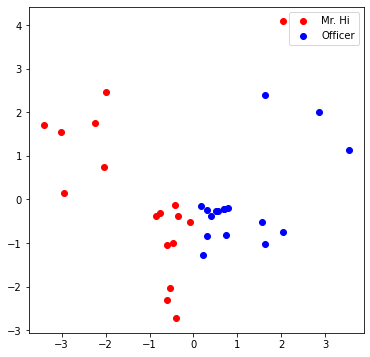

loss: 0.3129940629005432, accuracy: 0.9091
loss: 0.31243401765823364, accuracy: 0.9091
loss: 0.31187495589256287, accuracy: 0.9091
loss: 0.31131696701049805, accuracy: 0.9091
loss: 0.3107600212097168, accuracy: 0.9091
loss: 0.3102041184902191, accuracy: 0.9091
loss: 0.309649258852005, accuracy: 0.9091
loss: 0.3090953826904297, accuracy: 0.9091
loss: 0.3085426092147827, accuracy: 0.9091
loss: 0.3079908490180969, accuracy: 0.9091
loss: 0.3074401617050171, accuracy: 0.9091
loss: 0.30689048767089844, accuracy: 0.9091
loss: 0.30634185671806335, accuracy: 0.9091
loss: 0.30579426884651184, accuracy: 0.9109
loss: 0.3052477538585663, accuracy: 0.9109
loss: 0.3047022521495819, accuracy: 0.9109
loss: 0.3041577935218811, accuracy: 0.9109
loss: 0.30361437797546387, accuracy: 0.9127
loss: 0.3030720353126526, accuracy: 0.9127
loss: 0.30253079533576965, accuracy: 0.9127
loss: 0.3019905388355255, accuracy: 0.9127
loss: 0.30145135521888733, accuracy: 0.9127
loss: 0.3009132444858551, accuracy: 0.9127
los

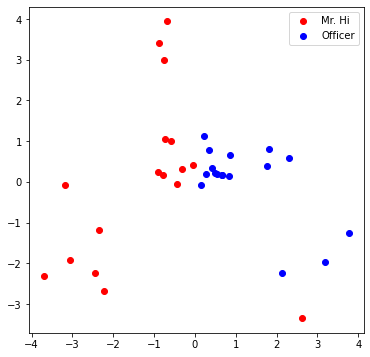

loss: 0.262225478887558, accuracy: 0.9251
loss: 0.2617698609828949, accuracy: 0.9251
loss: 0.261315256357193, accuracy: 0.9251
loss: 0.2608615756034851, accuracy: 0.9269
loss: 0.26040881872177124, accuracy: 0.9269
loss: 0.2599569857120514, accuracy: 0.9269
loss: 0.25950610637664795, accuracy: 0.9269
loss: 0.25905612111091614, accuracy: 0.9269
loss: 0.25860708951950073, accuracy: 0.9269
loss: 0.25815901160240173, accuracy: 0.9269
loss: 0.25771188735961914, accuracy: 0.9269
loss: 0.257265567779541, accuracy: 0.9269
loss: 0.2568202614784241, accuracy: 0.9269
loss: 0.25637584924697876, accuracy: 0.9269
loss: 0.25593236088752747, accuracy: 0.9287
loss: 0.2554897665977478, accuracy: 0.9287
loss: 0.25504812598228455, accuracy: 0.9287
loss: 0.2546073794364929, accuracy: 0.9287
loss: 0.25416749715805054, accuracy: 0.9305
loss: 0.25372856855392456, accuracy: 0.9305
loss: 0.2532905340194702, accuracy: 0.9323
loss: 0.2528534233570099, accuracy: 0.9323
loss: 0.2524172067642212, accuracy: 0.9323
los

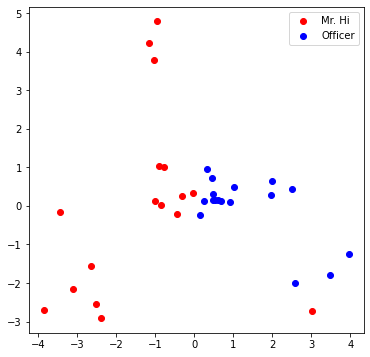

loss: 0.22125396132469177, accuracy: 0.9501
loss: 0.22089342772960663, accuracy: 0.9501
loss: 0.22053395211696625, accuracy: 0.9501
loss: 0.22017554938793182, accuracy: 0.9501
loss: 0.21981820464134216, accuracy: 0.9501
loss: 0.21946194767951965, accuracy: 0.9501
loss: 0.2191067487001419, accuracy: 0.9501
loss: 0.21875262260437012, accuracy: 0.9501
loss: 0.2183995395898819, accuracy: 0.9501
loss: 0.21804754436016083, accuracy: 0.9501
loss: 0.21769660711288452, accuracy: 0.9519
loss: 0.21734677255153656, accuracy: 0.9519
loss: 0.21699801087379456, accuracy: 0.9519
loss: 0.21665030717849731, accuracy: 0.9519
loss: 0.21630369126796722, accuracy: 0.9519
loss: 0.21595819294452667, accuracy: 0.9519
loss: 0.2156137377023697, accuracy: 0.9519
loss: 0.21527038514614105, accuracy: 0.9519
loss: 0.21492812037467957, accuracy: 0.9519
loss: 0.21458692848682404, accuracy: 0.9519
loss: 0.21424685418605804, accuracy: 0.9537
loss: 0.21390783786773682, accuracy: 0.9537
loss: 0.21356990933418274, accuracy

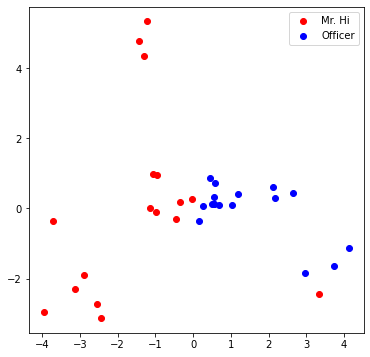

loss: 0.19038306176662445, accuracy: 0.9661
loss: 0.1901216208934784, accuracy: 0.9661
loss: 0.1898609846830368, accuracy: 0.9661
loss: 0.1896011233329773, accuracy: 0.9661
loss: 0.1893419325351715, accuracy: 0.9661
loss: 0.189083531498909, accuracy: 0.9661
loss: 0.1888258308172226, accuracy: 0.9661
loss: 0.18856893479824066, accuracy: 0.9661
loss: 0.18831270933151245, accuracy: 0.9661
loss: 0.18805721402168274, accuracy: 0.9661
loss: 0.18780244886875153, accuracy: 0.9661
loss: 0.18754833936691284, accuracy: 0.9661
loss: 0.18729503452777863, accuracy: 0.9661
loss: 0.18704237043857574, accuracy: 0.9661
loss: 0.18679045140743256, accuracy: 0.9661
loss: 0.18653914332389832, accuracy: 0.9661
loss: 0.18628856539726257, accuracy: 0.9661
loss: 0.18603865802288055, accuracy: 0.9661
loss: 0.18578948080539703, accuracy: 0.9679
loss: 0.18554092943668365, accuracy: 0.9679
loss: 0.1852930188179016, accuracy: 0.9679
loss: 0.18504579365253448, accuracy: 0.9679
loss: 0.1847992241382599, accuracy: 0.96

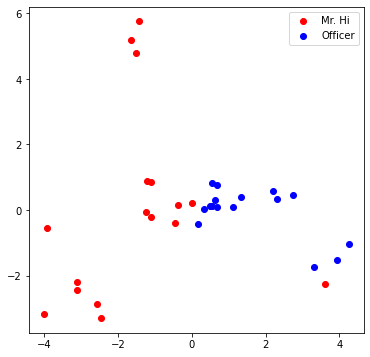

loss: 0.1672457754611969, accuracy: 0.9697
loss: 0.16703829169273376, accuracy: 0.9697
loss: 0.16683118045330048, accuracy: 0.9697
loss: 0.16662438213825226, accuracy: 0.9697
loss: 0.16641797125339508, accuracy: 0.9697
loss: 0.16621191799640656, accuracy: 0.9697
loss: 0.16600623726844788, accuracy: 0.9697
loss: 0.16580086946487427, accuracy: 0.9697
loss: 0.16559582948684692, accuracy: 0.9697
loss: 0.16539116203784943, accuracy: 0.9697
loss: 0.16518685221672058, accuracy: 0.9697
loss: 0.16498292982578278, accuracy: 0.9697
loss: 0.16477926075458527, accuracy: 0.9697
loss: 0.1645759493112564, accuracy: 0.9697
loss: 0.1643729954957962, accuracy: 0.9697
loss: 0.16417038440704346, accuracy: 0.9697
loss: 0.16396813094615936, accuracy: 0.9697
loss: 0.16376613080501556, accuracy: 0.9697
loss: 0.163564532995224, accuracy: 0.9697
loss: 0.16336321830749512, accuracy: 0.9697
loss: 0.1631622612476349, accuracy: 0.9697
loss: 0.16296160221099854, accuracy: 0.9697
loss: 0.16276131570339203, accuracy: 0

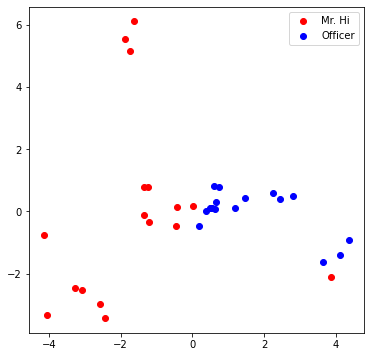

loss: 0.1482429951429367, accuracy: 0.9733
loss: 0.14807380735874176, accuracy: 0.9733
loss: 0.14790508151054382, accuracy: 0.9733
loss: 0.14773689210414886, accuracy: 0.9733
loss: 0.1475692242383957, accuracy: 0.9733
loss: 0.14740201830863953, accuracy: 0.9733
loss: 0.14723534882068634, accuracy: 0.9733
loss: 0.14706918597221375, accuracy: 0.9733
loss: 0.14690354466438293, accuracy: 0.9733
loss: 0.14673839509487152, accuracy: 0.9733
loss: 0.14657379686832428, accuracy: 0.9733
loss: 0.14640966057777405, accuracy: 0.9733
loss: 0.1462460607290268, accuracy: 0.9733
loss: 0.14608296751976013, accuracy: 0.9733
loss: 0.14592039585113525, accuracy: 0.9733
loss: 0.14575834572315216, accuracy: 0.9733
loss: 0.14559678733348846, accuracy: 0.9733
loss: 0.14543576538562775, accuracy: 0.9733
loss: 0.14527520537376404, accuracy: 0.9733
loss: 0.1451152116060257, accuracy: 0.9733
loss: 0.14495567977428436, accuracy: 0.9733
loss: 0.1447967141866684, accuracy: 0.9733
loss: 0.14463824033737183, accuracy: 

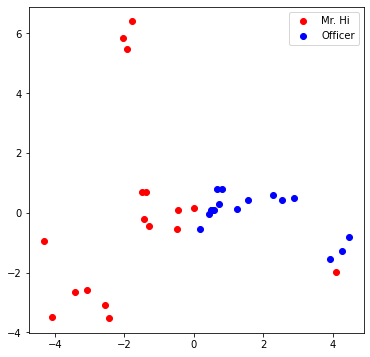

loss: 0.13371534645557404, accuracy: 0.9768
loss: 0.13359175622463226, accuracy: 0.9768
loss: 0.13346855342388153, accuracy: 0.9768
loss: 0.13334569334983826, accuracy: 0.9768
loss: 0.13322320580482483, accuracy: 0.9768
loss: 0.13310104608535767, accuracy: 0.9768
loss: 0.13297930359840393, accuracy: 0.9768
loss: 0.13285784423351288, accuracy: 0.9768
loss: 0.13273681700229645, accuracy: 0.9768
loss: 0.1326160877943039, accuracy: 0.9768
loss: 0.13249576091766357, accuracy: 0.9768
loss: 0.13237574696540833, accuracy: 0.9768
loss: 0.13225610554218292, accuracy: 0.9768
loss: 0.13213679194450378, accuracy: 0.9768
loss: 0.1320178210735321, accuracy: 0.9768
loss: 0.13189919292926788, accuracy: 0.9768
loss: 0.13178092241287231, accuracy: 0.9768
loss: 0.1316629946231842, accuracy: 0.9768
loss: 0.13154539465904236, accuracy: 0.9768
loss: 0.13142813742160797, accuracy: 0.9768
loss: 0.13131120800971985, accuracy: 0.9768
loss: 0.13119463622570038, accuracy: 0.9768
loss: 0.13107837736606598, accuracy

In [48]:
from torch.optim import SGD

def accuracy(pred, label):
  # TODO: Implement the accuracy function. This function takes the 
  # pred tensor (the resulting tensor after sigmoid) and the label 
  # tensor (torch.LongTensor). Predicted value greater than 0.5 will 
  # be classified as label 1. Else it will be classified as label 0.
  # The returned accuracy should be rounded to 4 decimal places. 
  # For example, accuracy 0.82956 will be rounded to 0.8296.

  accu = 0.0

  ############# Your code here ############
  pred_label = pred.ge(0.5) 
  accu = torch.sum(pred_label == label) / label.shape[0]
  accu = accu.item()

  #########################################

  return round(accu,4)

def train(emb, loss_fn, sigmoid, train_label, train_edge):
    
    epochs = 1000
    learning_rate = 0.3

    optimizer = SGD(emb.parameters(), lr=learning_rate, momentum=0.9)

    for i in range(epochs):
      optimizer.zero_grad()  # Clear gradients.

      product = torch.sum(torch.mul(emb(train_edge[0]),emb(train_edge[1])), axis = 1)
      pred = torch.sigmoid(product)
      loss = loss_fn(pred, train_label)
      loss.backward()  # Derive gradients.
      optimizer.step()  # Update parameters based on gradients.

    
      with torch.no_grad():
        accu = accuracy(pred, train_label)
        if i % 100 == 0:
          visualize_emb(emb)
        print("loss: {}, accuracy: {}".format(loss.item(), accu))
  

loss_fn = nn.BCELoss()
sigmoid = nn.Sigmoid()

# Generate the positive and negative labels
pos_label = torch.ones(pos_edge_index.shape[1], )
neg_label = torch.zeros(neg_edge_index.shape[1], )

# Concat positive and negative labels into one tensor
train_label = torch.cat([pos_label, neg_label], dim=0)

# Concat positive and negative edges into one tensor
# Since the network is very small, we do not split the edges into val/test sets
train_edge = torch.cat([pos_edge_index, neg_edge_index], dim=1)

train(emb, loss_fn, sigmoid, train_label, train_edge)

## Visualize the final node embeddings

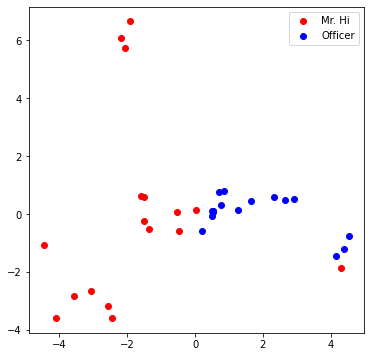

In [49]:
# Visualize the final learned embedding
visualize_emb(emb)